In [7]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import GPy
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

from numpy import genfromtxt
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing

from matplotlib import style
style.use('seaborn-white')

In [8]:
my_data = genfromtxt('../../../Data/deterministicCase/deterministicData.csv', delimiter=',')
theta_sim = my_data[:,0]
theta_d_sim = my_data[:,1]
x_sim = my_data[:,2]
x_d_sim = my_data[:,3]
forceIn = my_data[:,4]
theta_dd_sim = my_data[:,5]
x_dd_sim = my_data[:,6]

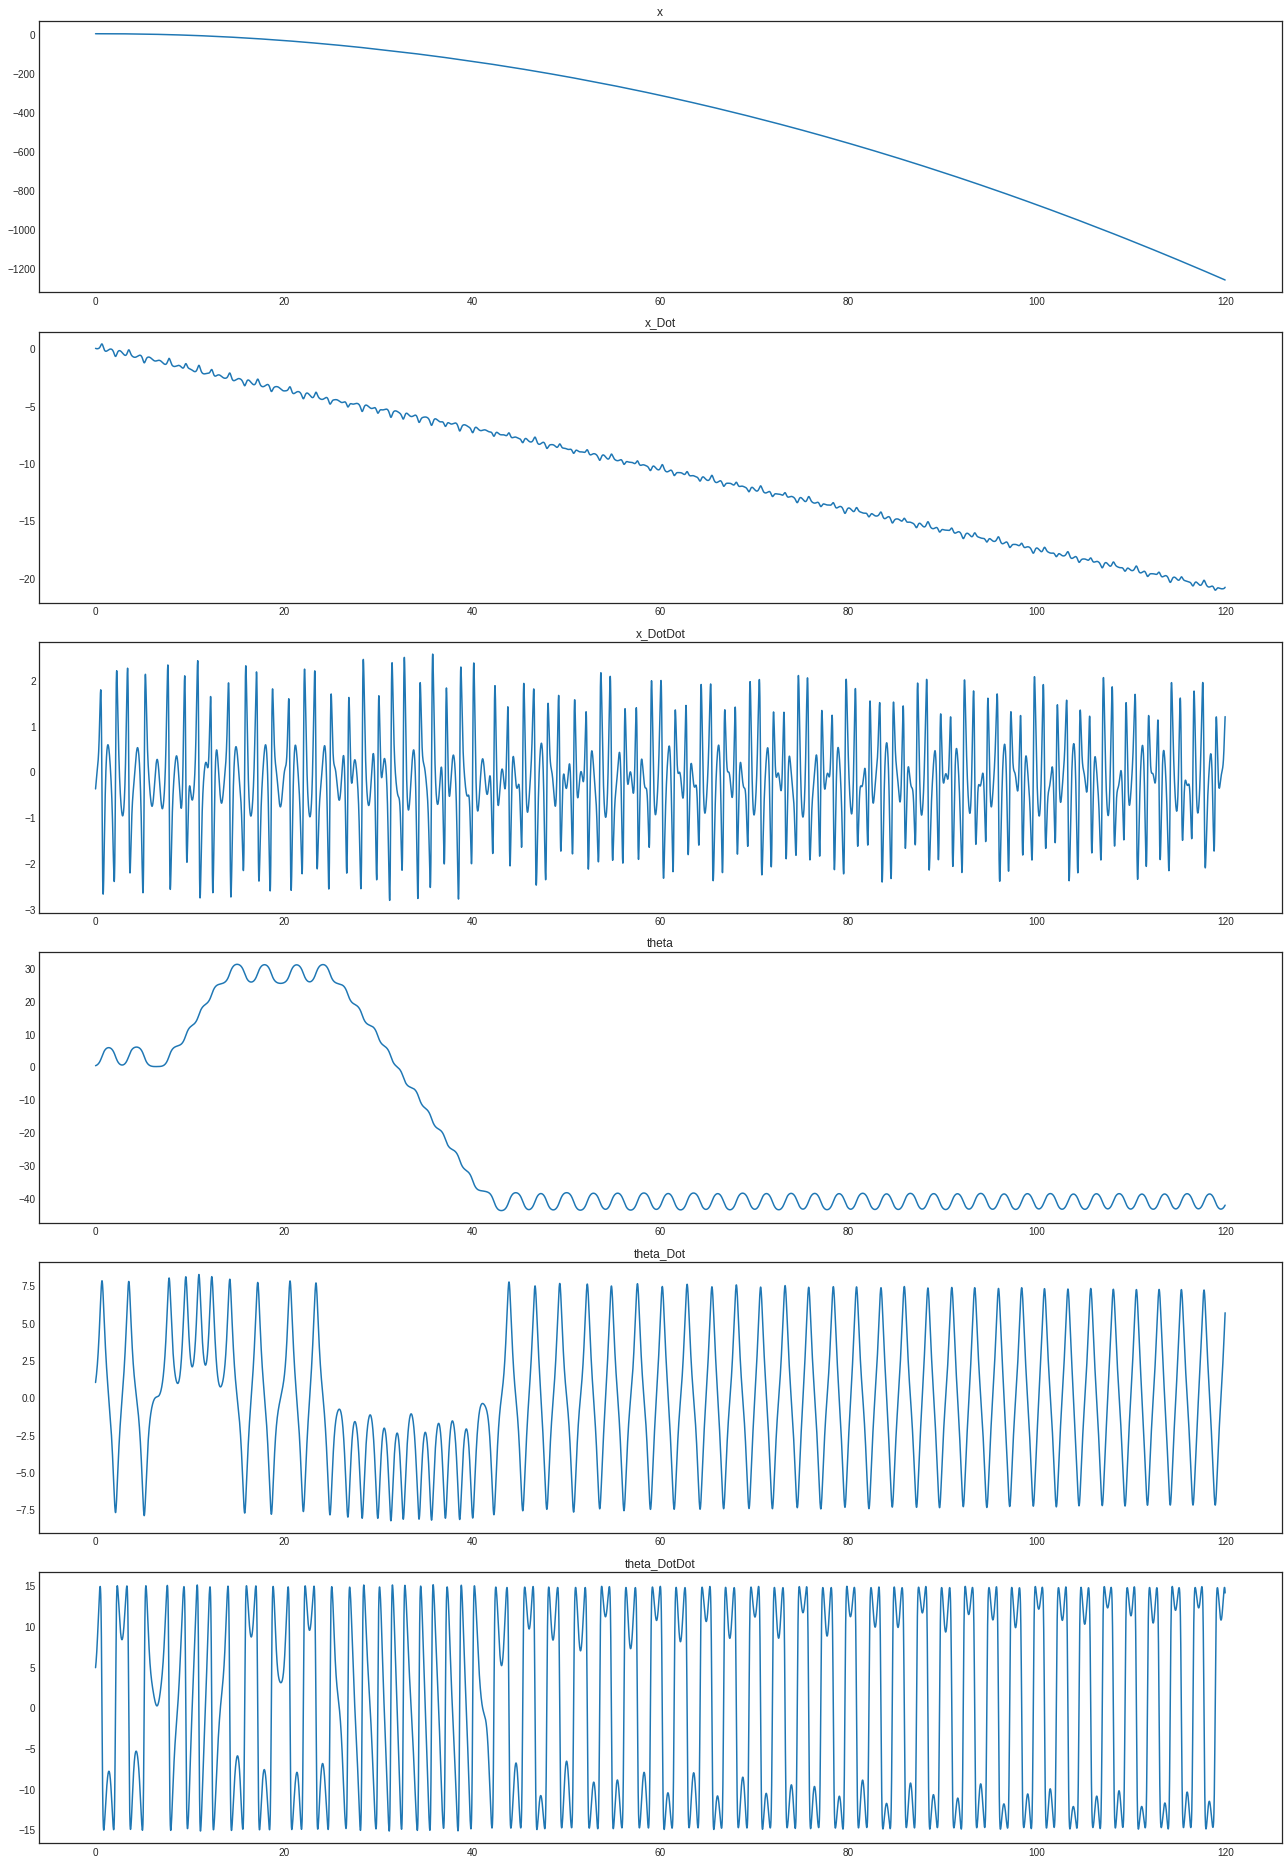

In [9]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

# GPyCoRegionalization

In [13]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

Y_train = np.stack((Y_train_theta, Y_train_x), axis=1) # For MultiOutput GP

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

X_prior = np.stack(((theta_sim-theta_sim_mean)/theta_sim_stdev,(theta_d_sim-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [ ]:
noise = 0.017

#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)

#myKernel = k1*k2
#myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
gpr = GPy.models.GPCoregionalizedRegression(X_list=[X_train, X_train], Y_list=[Y_train_theta, Y_train_x])

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize()

# Display optimized parameter values
display(gpr)

In [ ]:
np.save('../../learnedModels/deterministicCase/GPwithGPy/multi_RBF_GPy', gpr.param_array)

In [ ]:
mu_theta, cov_theta = gpr.predict(X_prior)